# ESM-2 Embedding Similarity Analysis for Mutations

<img src="../figures/esm_mutation.svg" alt="ESM-2 Embedding Similarity Analysis for Mutations" width="350px">

ESM-2 is one of the most advanced protein language models out there. It’s trained on millions of protein sequences using self-supervised learning, meaning it learns patterns and relationships without needing labeled data. What makes it special is that its embeddings—basically, how it represents proteins—capture both their structure and evolutionary history. That’s why it performs so well in tasks like predicting protein structures and figuring out their functions.

For our experiment, we used the 650-million parameter version of ESM-2 to test how well mutation-based token replacements in evoBPE preserve biological meaning. In simple terms, we wanted to see if swapping amino acids in a way that mimics real mutations keeps the original protein’s properties better than just making random substitutions. Even though mutation tokens are relatively rare in evoBPE’s training data, we wanted to check if they still lead to more biologically meaningful changes.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["HF_HOME"] = "/cta/share/users/esm"

In [2]:
from time import time
import sqlite3
import pandas as pd
from tqdm import tqdm
import numpy as np
from transformers import EsmTokenizer, EsmModel, EsmForMaskedLM
import torch
import torch.nn.functional as F
from tqdm import tqdm
from pandarallel import pandarallel
from Bio.Align import substitution_matrices
import ast
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
from scipy import stats

from vocabulary_functions import get_mutated, get_parents, set_difference, set_intersection, load_tokenizers, calc_agreement, calc_dice_idx_only

In [3]:
pandarallel.initialize(progress_bar=True, nb_workers=20)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load Datasets

In [4]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

uniref_id = '50'
df_protein = pd.read_sql(f"""SELECT Entry as uniprot_id, Sequence as sequence
                          FROM proteins
                          WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)""", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 512].reset_index(drop=True)

df_protein_sliced = pd.read_sql(f"SELECT uniprot_id, sequence FROM uniref{uniref_id}_domain_sliced_plddt70", conn)
df_protein_sliced = df_protein_sliced[df_protein_sliced['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

conn.close()

## Load Tokenizers

In [10]:
# 'dataset': {'uniref50', 'uniref90'}
# 'is_pretokenizer': {True, False}
# 'subs_matrix': {'blosum45', 'blosum62', 'pam70', 'pam250'}
# 'mutation_cutoff': {0.7, 0.8, 0.9}
# 'min_mutation_freq': {0, 0.05,. 0.005}
# 'min_mutation_len': {3}
# 'max_mutation_len': {12}
# 'vocab_size': list=[800, 1600, 3200, 6400, 12800, 25600, 51200]

vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.8,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.005,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum45',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'pam250',
        'mutation_cutoff': 0.8,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.9,
        'min_mutation_freq': 0.005,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    }
]

In [11]:
import json
from tokenizers import Tokenizer

tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

for vs in vocab_sizes:
    tokenizer_list[f'PUMA blosum62 0.9 0.005 {vs}'] = Tokenizer.from_file(f"/cta/share/users/mutbpe/tokenizers/blosum62_alldataset/1000000/hf_uniref50_mutbpe_0.7_3_12_0.05_{vs}.json")
    with open(f"/cta/share/users/mutbpe/tokenizers/blosum62_alldataset/1000000/uniref50_mutbpe_0.7_3_12_0.05_{vs}.json") as json_file:
        inner_vocab_list[f'PUMA blosum62 0.9 0.005 {vs}'] = json.load(json_file)

vocab_list = {name: list(set(tok.get_vocab().keys())) for name, tok in tokenizer_list.items()}
methods = [name[:-len(str(vocab_sizes[0]))-1] for name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn: mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}

inner_vocab_parents_list = {}
inner_vocab_mutated_list = {}
for k, v in inner_vocab_list.items():
    inner_vocab_parents_list[k] = get_parents(v)
    inner_vocab_mutated_list[k] = get_mutated(v)

for tokenizer_name in tokenizer_list.keys():
    for mutated_token, mutated_token_attr in inner_vocab_mutated_list[tokenizer_name].items():
        parent_token = mutated_token_attr['parent']
        inner_vocab_parents_list[tokenizer_name][parent_token]['mutations'] = inner_vocab_parents_list[tokenizer_name][parent_token].get('mutations', []) + [mutated_token]

In [12]:
# --- Vocabulary Lineage Construction ---
vocab_lineage_list = {}
for k, v in inner_vocab_list.items():
    vocab_lineage_list[k] = {token: {
        'frequency': -1, 'order': -1, 'parent_pair': [], 'parent_mutation': "",
        'parent_mutation_similarity': -1, 'partner_pair_self': False,
        'partner_pair_left': [], 'partner_pair_right': [], 'child_pair': [], 'child_mutation': []
    } for token in v.keys()}

for method_name, vocab in tqdm(inner_vocab_list.items(), desc="Building Vocabulary Lineage"):
    for token, inner_elements in vocab.items():
        lineage = vocab_lineage_list[method_name][token]
        lineage['frequency'] = inner_elements.get('frequency', -1)
        lineage['order'] = inner_elements.get('order', -1)
        lineage['parent_pair'] = inner_elements.get('pair', [])
        lineage['parent_mutation'] = inner_elements.get('parent', "")
        lineage['parent_mutation_similarity'] = inner_elements.get('similarity', -1)

        if 'pair' in inner_elements:
            p1, p2 = inner_elements['pair']
            if p1 == p2:
                vocab_lineage_list[method_name][p1]['partner_pair_self'] = True
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
            else:
                vocab_lineage_list[method_name][p1]['partner_pair_right'].append(p2)
                vocab_lineage_list[method_name][p2]['partner_pair_left'].append(p1)
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
                vocab_lineage_list[method_name][p2]['child_pair'].append(token)
        if 'parent' in inner_elements:
            parent = inner_elements['parent']
            vocab_lineage_list[method_name][parent]['child_mutation'].append(token)

Building Vocabulary Lineage: 100%|██████████| 48/48 [00:00<00:00, 90.60it/s] 


In [13]:
for name, tokenizer in tqdm(list(tokenizer_list.items())):
    if 'pre' in name:
        df_protein_sliced[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_sliced['sequence'])]
    else:
        df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


In [14]:
df_protein_sliced = df_protein_sliced.groupby('uniprot_id').sum().reset_index()
df_protein = df_protein.set_index(['uniprot_id', 'sequence']).join(df_protein_sliced.set_index(['uniprot_id', 'sequence'])).reset_index()
df_protein.head()

,uniprot_id,sequence,PUMA blosum62 0.7 0.05 800,PUMA blosum62 0.7 0.05 1600,PUMA blosum62 0.7 0.05 3200,PUMA blosum62 0.7 0.05 6400,PUMA blosum62 0.7 0.05 12800,PUMA blosum62 0.7 0.05 25600,PUMA blosum62 0.8 0.05 800,PUMA blosum62 0.8 0.05 1600,...,PUMA blosum62 0.9 0.005 3200,PUMA blosum62 0.9 0.005 6400,PUMA blosum62 0.9 0.005 12800,PUMA blosum62 0.9 0.005 25600,PUMA pre blosum62 0.7 0.05 800,PUMA pre blosum62 0.7 0.05 1600,PUMA pre blosum62 0.7 0.05 3200,PUMA pre blosum62 0.7 0.05 6400,PUMA pre blosum62 0.7 0.05 12800,PUMA pre blosum62 0.7 0.05 25600
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,"[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QRDL, EAEH, VL, PSP, GG, ...","[MEL, SA, EYL, REKL, QRDL, EAEH, VL, PSP, GGVG...","[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...",...,"[ME, LS, AE, YLR, EK, LQ, RD, LE, AE, HV, LP, ...","[ME, LS, AE, YLR, EK, LQ, RD, LE, AE, HV, LP, ...","[ME, LSAE, YLR, EK, LQ, RD, LE, AE, HV, LPSP, ...","[ME, LSAE, YLR, EK, LQ, RDLE, AEHV, LPSP, GGVG...","[M, EL, SA, E, YL, R, EKL, QR, DL, EA, EH, VL,...","[M, EL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, P...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, R, EKL, QR, DL, EA, EH, VL, PSP...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GG, ...","[MEL, SA, EYL, REKL, QRDL, EA, EHVL, PSP, GGVG..."
1,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,"[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GG, V,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...","[M, FR, RL, TFA, QLL, FA, T, VLG, IA, GGV, YI,...","[M, FR, RL, TFA, QLL, FA, T, VLG, IA, GGV, YI,...","[M, FRRL, TFA, QLL, FAT, VLG, IA, GGV, YI, FQ,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GG, V,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...",...,"[MF, RR, LTF, AQ, LLF, AT, VLG, I, AGG, V, YI,...","[MF, RR, LTF, AQ, LLF, AT, VLGI, AGGV, YI, FQ,...","[MF, RR, LTF, AQ, LLF, AT, VLGI, AGGV, YI, FQ,...","[MFRR, LTF, AQ, LLF, AT, VLGI, AGGV, YI, FQ, P...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GG, V,...","[M, FR, RL, T, FA, QLL, FA, T, VLG, IA, GGV, Y...","[M, FR, RL, T, FA, QLL, FAT, VLG, IA, GGV, YI,...","[M, FR, RL, TFA, QLL, FAT, VLG, IA, GGV, YI, F...","[M, FR, RL, TFA, QLL, FAT, VLG, IA, GGV, YI, F...","[M, FRRL, TFA, QLL, FAT, VLG, IA, GGV, YI, FQ,..."
2,A0A0C5B5G6,MRWQEMGYIFYPRKLR,"[M, RW, Q, E, MG, YI, FY, PR, KL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QEMG, YI, FY, PRKL, R]","[MRW, QEMG, YI, FY, PRKL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]",...,"[M, RW, QE, MG, YI, FYP, RK, LR]","[MRW, QE, MG, YI, FYP, RKLR]","[MRW, QE, MG, YI, FYP, RKLR]","[MRW, QE, MG, YI, FYP, RKLR]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QE, MG, YI, FY, PR, KL, R]","[M, RW, QEMG, YI, FY, PR, KL, R]","[M, RW, QEMG, YI, FY, PRKL, R]","[M, RW, QEMG, YI, FY, PRKL, R]"
3,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,"[M, TQ, R, AG, AA, ML, PSA, LL, LL, CV, PG, CL...","[M, TQ, R, AGAA, ML, PSA, LLLL, CV, PG, CL, TV...","[M, TQR, AGAA, ML, PSA, LLLL, CV, PG, CL, TV, ...","[M, TQR, AGAA, ML, PSA, LLLL, CV, PG, CL, TV, ...","[M, TQR, AGAA, ML, PSA, LLLL, CV, PG, CL, TVSG...","[M, TQR, AGAA, ML, PSA, LLLL, CV, PGCL, TVSG, ...","[M, TQ, R, AG, AA, ML, PSA, LL, LL, CV, PG, CL...","[M, TQ, RAG, AA, ML, PSA, LLLL, CV, PG, CL, TV...",...,"[M, TQ, RAG, AAM, LP, SALL, LL, CV, PG, C, LTV...","[MTQ, RAG, AAM, LP, SALL, LL, CV, PG, C, LTV, ...","[MTQ, RAG, AAM, LP, SALL, LL, CV, PG, C, LTV, ...","[MTQ, RAG, AAM, LP, SALL, LL, CV, PG, C, LTV, ...","[M, TQ, R, AG, AA, ML, PSA, LL, LL, CV, PG, CL...","[M, TQ, R, AGAA, ML, PSA, LLLL, C

In [15]:
# --- Pre-computation Function ---

def precompute_alternatives(sub_matrix):
    """
    Pre-computes a lookup table for amino acid substitutions with better scores.
    """
    print("Pre-computing alternative amino acid scores...")
    AMINO_ACIDS = 'ABCDEFGHIKLMNPQRSTVWYZ'
    precomputed_alternatives = {orig_aa: {} for orig_aa in AMINO_ACIDS}

    for orig_aa in tqdm(AMINO_ACIDS):
        for mut_aa in AMINO_ACIDS:
            if orig_aa == mut_aa:
                continue
            
            try:
                score_mutation = sub_matrix[(orig_aa, mut_aa)]
            except KeyError:
                continue

            possible_alternatives = []
            for alt_aa in AMINO_ACIDS:
                if alt_aa in (orig_aa, mut_aa):
                    continue
                try:
                    score_alternative = sub_matrix[(orig_aa, alt_aa)]
                    if score_alternative >= score_mutation:
                        possible_alternatives.append((alt_aa, score_alternative-score_mutation))
                except KeyError:
                    continue
            
            # Sort by score (descending) and store only the amino acid
            possible_alternatives.sort(key=lambda x: x[1], reverse=True)
            # precomputed_alternatives[orig_aa][mut_aa] = [alt[0] for alt in possible_alternatives]
            precomputed_alternatives[orig_aa][mut_aa] = possible_alternatives.copy()
            
    return precomputed_alternatives


# --- Enhanced Helper Functions ---

def find_alternative_replacement_optimized(
    original_token, 
    mutation_replacement, 
    replacement_pool_set, 
    precomputed_alts,
    vocab_lineage
):
    """
    Finds an alternative token using the pre-computed lookup table with score-based selection.

    Args:
        original_token (str): The original token from the sequence.
        mutation_replacement (str): The token chosen from siblings/children.
        replacement_pool_set (set): A set of sibling/child mutations for fast lookups.
        precomputed_alts (dict): The pre-computed table of better amino acids with scores.
        vocab_lineage (dict): Dictionary describing token mutation relationships.

    Returns:
        str: A valid alternative token with highest score, or the original mutation_replacement if none is found.
    """
    if len(original_token) != len(mutation_replacement):
        return mutation_replacement, 0

    diff_positions = [
        i for i, (orig_aa, mut_aa) in enumerate(zip(original_token, mutation_replacement)) 
        if orig_aa != mut_aa
    ]

    if not diff_positions:
        return mutation_replacement, 0

    # Get mutation replacement order for comparison
    mutation_order = vocab_lineage.get(mutation_replacement, {}).get('order', 0)
    
    # Generate all possible alternative tokens
    alternative_candidates = []
    
    def generate_alternatives(token_list, pos_index, current_score):
        if pos_index >= len(diff_positions):
            # Complete alternative generated
            new_token = "".join(token_list)
            alternative_candidates.append((new_token, current_score))
            return
        
        pos = diff_positions[pos_index]
        original_aa = original_token[pos]
        mutated_aa = mutation_replacement[pos]
        
        # Get alternatives for this position from precomputed table
        alternatives_with_scores = precomputed_alts.get(original_aa, {}).get(mutated_aa, [])
        
        for alt_aa, score in alternatives_with_scores:
            new_token_list = token_list.copy()
            new_token_list[pos] = alt_aa
            generate_alternatives(new_token_list, pos_index + 1, current_score + score)
    
    # Start generation with mutation_replacement as base
    start_token_list = list(mutation_replacement)
    generate_alternatives(start_token_list, 0, 0)
    
    # Sort by score in descending order
    alternative_candidates.sort(key=lambda x: x[1], reverse=True)
    
    # Find the highest scoring alternative that meets constraints
    for new_token, score in alternative_candidates:
        if (new_token not in replacement_pool_set) and (new_token in vocab_lineage) and (vocab_lineage[new_token].get('order', 0) > mutation_order):
            return new_token, score
    
    # If no valid alternative found, return original mutation
    return mutation_replacement, 0


def create_random_alternative_baseline(original_token, mutation_replacement, alternative_replacement, sub_matrix):
    """
    Create random alternative replacements matched for BLOSUM scores.
    """
    if len(original_token) != len(mutation_replacement):
        return mutation_replacement
    
    AMINO_ACIDS = list('ABCDEFGHIKLMNPQRSTVWYZ')
    alternative_token = list(mutation_replacement)
    
    for i, (orig_aa, mut_aa, alt_aa) in enumerate(zip(original_token, mutation_replacement, alternative_replacement)):
        if orig_aa != mut_aa and mut_aa != alt_aa:
            alternative_token[i] = random.choice([aa for aa in AMINO_ACIDS if aa != orig_aa])
            # try:
            #     target_score = sub_matrix[(orig_aa, mut_aa)]
            #     # Find amino acids with similar BLOSUM scores
            #     candidates = []
            #     for aa in AMINO_ACIDS:
            #         if aa != orig_aa and aa != mut_aa:
            #             try:
            #                 score = sub_matrix[(orig_aa, aa)]
            #                 if abs(score - target_score) <= 1:  # Allow ±1 score difference
            #                     candidates.append(aa)
            #             except KeyError:
            #                 continue
                
            #     if candidates:
            #         alternative_token[i] = random.choice(candidates)
            # except KeyError:
            #     continue
    
    return ''.join(alternative_token)


# --- Enhanced Main Function ---

def run_mutation_experiment_optimized(df_protein, vocab_lineage_list, sub_matrix_precomputed_alternatives, create_baseline=True):
    """
    Generates mutated, alternative, and baseline sequences efficiently.
    """
    df_results = df_protein.copy()
    token_cols = list(tokenizer_list.keys())
    change_counters = {}
    change_scores = {}

    for col_name in token_cols:
        print(f"\nProcessing column: {col_name}")
        change_counters[col_name] = 0
        change_scores[col_name] = 0

        sub_matrix_name = col_name.split()[2] if col_name.split()[1] == 'pre' else col_name.split()[1]
        precomputed_alternatives = sub_matrix_precomputed_alternatives[sub_matrix_name]
        sub_matrix = substitution_matrices.load(sub_matrix_name.upper())
        
        all_mutated_sequences = []
        all_alternative_sequences = []
        all_baseline_sequences = [] if create_baseline else None
        
        vocab_lineage = vocab_lineage_list.get(col_name, {})

        for tokenized_sequence in tqdm(df_results[col_name]):
            new_mutated_sequence = []
            new_alternative_sequence = []
            new_baseline_sequence = [] if create_baseline else None
            
            for token in tokenized_sequence:
                token_info = vocab_lineage.get(token)
                
                if not token_info:
                    new_mutated_sequence.append(token)
                    new_alternative_sequence.append(token)
                    if create_baseline:
                        new_baseline_sequence.append(token)
                    continue
                
                # if 'child_mutation' in token_info and token_info['child_mutation']:
                #     replacement_pool = token_info.get('child_mutation', [])
                #     replacement_pool_set = set(replacement_pool + [token])
                if 'parent_mutation' in token_info and token_info['parent_mutation']:
                    parent_mutation_token = token_info['parent_mutation']
                    replacement_pool = vocab_lineage[parent_mutation_token].get('child_mutation', [])
                    replacement_pool_set = set(replacement_pool + [token, parent_mutation_token])
                else:
                    new_mutated_sequence.append(token)
                    new_alternative_sequence.append(token)
                    if create_baseline:
                        new_baseline_sequence.append(token)
                    continue

                

                for mutation_replacement in replacement_pool:
                    alternative_replacement, alt_score = find_alternative_replacement_optimized(
                        token, 
                        mutation_replacement, 
                        replacement_pool_set, 
                        precomputed_alternatives,
                        vocab_lineage
                    )
                    
                    if alternative_replacement != mutation_replacement:
                        new_mutated_sequence.append(mutation_replacement)
                        new_alternative_sequence.append(alternative_replacement)
                        if create_baseline:
                            baseline_replacement = create_random_alternative_baseline(
                                token, mutation_replacement, alternative_replacement, sub_matrix
                            )
                            new_baseline_sequence.append(baseline_replacement)
                        change_counters[col_name] += 1
                        change_scores[col_name] += alt_score
                        break
                else:
                    new_mutated_sequence.append(token)
                    new_alternative_sequence.append(token)
                    if create_baseline:
                        new_baseline_sequence.append(token)

            all_mutated_sequences.append(new_mutated_sequence)
            all_alternative_sequences.append(new_alternative_sequence)
            if create_baseline:
                all_baseline_sequences.append(new_baseline_sequence)

        df_results[f'{col_name} mutated'] = all_mutated_sequences
        df_results[f'{col_name} alternative'] = all_alternative_sequences
        if create_baseline:
            df_results[f'{col_name} baseline'] = all_baseline_sequences
        print(f"Changes: {change_counters[col_name]}, Scores: {change_scores[col_name]}, Score perc: {change_scores[col_name] / change_counters[col_name] if change_counters[col_name] > 0 else 0}")
        
    return df_results, change_counters, change_scores

In [ ]:
# --- Enhanced ESM-2 Functions ---

# facebook/model_name
# Checkpoint name	    Num layers  Num parameters  Dim count
# esm2_t48_15B_UR50D	48	        15B             5120       
# esm2_t36_3B_UR50D	    36          3B              2560        
# esm2_t33_650M_UR50D	33          650M            1280     
# esm2_t30_150M_UR50D	30          150M            640      
# esm2_t12_35M_UR50D	12          35M             480      
# esm2_t6_8M_UR50D	    6           8M              320      

def get_esm2_model_and_tokenizer(model_name="facebook/esm2_t33_650M_UR50D"):
    """Initialize ESM-2 model and tokenizer."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    tokenizer = EsmTokenizer.from_pretrained(model_name)
    model = EsmForMaskedLM.from_pretrained(model_name).to(device)
    model.eval()
    
    print(f"Loaded ESM-2 model: {model_name}")
    return model, tokenizer, device


def get_esm2_embeddings_and_logits_batch(sequences, model, tokenizer, device, batch_size=32, max_length=1024, extract_layers=None):
    """
    Get ESM-2 embeddings and logits for multiple protein sequences in batches.
    
    Args:
        extract_layers: List of layer indices to extract embeddings from (default: last layer only)
    """
    if extract_layers is None:
        extract_layers = [-1]  # Last layer only
    
    sequence_data = {}
    
    for i in tqdm(range(0, len(sequences), batch_size), desc="Processing embedding batches"):
        batch_sequences = sequences[i:i + batch_size]
        
        inputs = tokenizer(
            batch_sequences, 
            return_tensors="pt", 
            padding='longest', 
            truncation=True, 
            max_length=max_length
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            batch_logits = outputs.logits
            hidden_states = outputs.hidden_states
        
        for j, seq in enumerate(batch_sequences):
            seq_len = len(seq)
            
            # Store logits (for probability analysis)
            logits = batch_logits[j, 1:seq_len+1].cpu()  # Remove <cls>, keep actual sequence
            
            # Store embeddings from specified layers
            embeddings = {}
            for layer_idx in extract_layers:
                layer_embeddings = hidden_states[layer_idx][j, 1:seq_len+1].cpu()
                embeddings[layer_idx] = layer_embeddings
            
            sequence_data[seq] = {
                'logits': logits,
                'embeddings': embeddings
            }
    
    return sequence_data

def get_masked_logits_batch(sequence_position_pairs, model, tokenizer, device, batch_size=32, max_length=1024):
    """
    Get masked logits for multiple (sequence, position) pairs in batches.
    
    Args:
        sequence_position_pairs: List of (sequence, position) tuples
        model: ESM-2 model
        tokenizer: ESM tokenizer
        device: torch device
        batch_size: Number of sequences to process in each batch
        max_length: Maximum sequence length
    
    Returns:
        Dict mapping (sequence, position) to masked position logits
    """
    masked_logits = {}
    
    # Create all masked sequences
    masked_sequences = []
    sequence_position_map = {}
    
    for seq, pos in sequence_position_pairs:
        if pos >= len(seq):
            continue
        
        seq_list = list(seq)
        seq_list[pos] = tokenizer.mask_token
        masked_seq = ''.join(seq_list)
        
        masked_sequences.append(masked_seq)
        sequence_position_map[len(masked_sequences) - 1] = (seq, pos)
    
    # Process masked sequences in batches
    for i in tqdm(range(0, len(masked_sequences), batch_size), desc="Processing masked sequences"):
        batch_sequences = masked_sequences[i:i + batch_size]
        
        # Tokenize batch
        inputs = tokenizer(
            batch_sequences, 
            return_tensors="pt", 
            padding='longest', 
            truncation=True, 
            max_length=max_length
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            batch_logits = outputs.logits
        
        # Extract logits at masked positions
        for j, masked_seq in enumerate(batch_sequences):
            batch_idx = i + j
            if batch_idx not in sequence_position_map:
                continue
                
            original_seq, position = sequence_position_map[batch_idx]
            
            # Find mask token position in tokenized sequence
            mask_token_indices = (inputs.input_ids[j] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0]
            
            if len(mask_token_indices) > 0:
                mask_pos = mask_token_indices[0]
                position_logits = batch_logits[j, mask_pos, :].cpu()
                masked_logits[(original_seq, position)] = position_logits
    
    return masked_logits

In [ ]:
# --- Analysis Functions ---

def reconstruct_sequence_from_tokens(tokens):
    """Reconstruct amino acid sequence from tokens."""
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)
    return ''.join(tokens)


def find_differing_amino_acid_positions(original_seq, mutated_seq, alternative_seq, baseline_seq=None):
    """Find positions where amino acids differ between sequences."""
    differing_positions = []
    sequences = [mutated_seq, alternative_seq]
    if baseline_seq:
        sequences.append(baseline_seq)
    
    min_len = min(len(original_seq), *[len(seq) for seq in sequences])
    
    for i in range(min_len):
        original_aa = original_seq[i]
        # differs = any(seq[i] != original_aa for seq in sequences)
        differs = all(seq[i] != original_aa for seq in sequences)
        if differs:
            differing_positions.append(i)
    
    return differing_positions


def normalize_embeddings(embeddings, method='l2'):
    """Normalize embeddings using different methods."""
    if method == 'l2':
        return F.normalize(embeddings, p=2, dim=-1)
    elif method == 'center_l2':
        centered = embeddings - embeddings.mean(dim=0, keepdim=True)
        return F.normalize(centered, p=2, dim=-1)
    else:
        return embeddings


def compute_similarities_multiple_methods(original_emb, comparison_emb, positions, method='concat'):
    """Compute similarities using different aggregation methods."""
    if not positions or original_emb is None or comparison_emb is None:
        return None
    
    # Ensure positions are within bounds
    max_pos = min(original_emb.shape[0] - 1, comparison_emb.shape[0] - 1)
    valid_positions = [pos for pos in positions if pos <= max_pos]
    
    if not valid_positions:
        return None
    
    if method == 'concat':
        # Concatenate embeddings at differing positions
        orig_concat = original_emb[valid_positions].flatten().unsqueeze(0).numpy()
        comp_concat = comparison_emb[valid_positions].flatten().unsqueeze(0).numpy()
        return cosine_similarity(orig_concat, comp_concat)[0, 0]
    
    elif method == 'position_wise':
        # Compute position-wise similarities and average
        similarities = []
        for pos in valid_positions:
            orig_vec = original_emb[pos].unsqueeze(0).numpy()
            comp_vec = comparison_emb[pos].unsqueeze(0).numpy()
            sim = cosine_similarity(orig_vec, comp_vec)[0, 0]
            similarities.append(sim)
        return np.mean(similarities)
    
    elif method == 'global_mean':
        # Global mean pooling over entire sequence
        orig_mean = original_emb.mean(dim=0).unsqueeze(0).numpy()
        comp_mean = comparison_emb.mean(dim=0).unsqueeze(0).numpy()
        return cosine_similarity(orig_mean, comp_mean)[0, 0]
    
    elif method == 'local_window':
        # Local window around each changed position
        window_size = 8
        similarities = []
        for pos in valid_positions:
            start = max(0, pos - window_size)
            end = min(original_emb.shape[0], pos + window_size + 1)
            
            orig_window = original_emb[start:end].mean(dim=0).unsqueeze(0).numpy()
            comp_window = comparison_emb[start:end].mean(dim=0).unsqueeze(0).numpy()
            sim = cosine_similarity(orig_window, comp_window)[0, 0]
            similarities.append(sim)
        return np.mean(similarities)


def compute_rank_based_metrics_optimized(original_seq, mutated_seq, alternative_seq, baseline_seq, differing_positions, masked_logits_dict, tokenizer):
    """Compute rank-based metrics using precomputed masked logits."""
    rank_metrics = {'orig_wins_vs_mut': 0, 'orig_wins_vs_alt': 0, 'orig_wins_vs_base': 0, 'mut_wins_vs_alt': 0, 'mut_wins_vs_base': 0, 'alt_wins_vs_base': 0, 'total_positions': 0}
    
    if not differing_positions:
        return rank_metrics
    
    for pos in differing_positions:
        if pos >= len(original_seq):
            continue
            
        # Get precomputed masked logits
        masked_logits = masked_logits_dict.get((original_seq, pos))
        if masked_logits is None:
            continue
        
        # Convert to probabilities
        position_probs = F.softmax(masked_logits, dim=-1)
        
        # Get amino acids at this position
        orig_aa = original_seq[pos]
        mut_aa = mutated_seq[pos] if pos < len(mutated_seq) else orig_aa
        alt_aa = alternative_seq[pos] if pos < len(alternative_seq) else orig_aa
        base_aa = baseline_seq[pos] if baseline_seq and pos < len(baseline_seq) else orig_aa
        
        # Get token IDs for amino acids
        orig_token_id = tokenizer.convert_tokens_to_ids(orig_aa)
        mut_token_id = tokenizer.convert_tokens_to_ids(mut_aa)
        alt_token_id = tokenizer.convert_tokens_to_ids(alt_aa)
        base_token_id = tokenizer.convert_tokens_to_ids(base_aa) if baseline_seq else None
        
        # Get probabilities
        if all(tid is not None for tid in [orig_token_id, mut_token_id, alt_token_id]):
            orig_prob = position_probs[orig_token_id].item()
            mut_prob = position_probs[mut_token_id].item()
            alt_prob = position_probs[alt_token_id].item()
            
            # Compare original vs others
            if orig_prob > mut_prob:
                rank_metrics['orig_wins_vs_mut'] += 1
            if orig_prob > alt_prob:
                rank_metrics['orig_wins_vs_alt'] += 1
            
            # Compare mutation vs alternative
            if mut_prob > alt_prob:
                rank_metrics['mut_wins_vs_alt'] += 1
            
            # Compare with baseline if available
            if base_token_id is not None:
                base_prob = position_probs[base_token_id].item()
                if orig_prob > base_prob:
                    rank_metrics['orig_wins_vs_base'] += 1
                if mut_prob > base_prob:
                    rank_metrics['mut_wins_vs_base'] += 1
                if alt_prob > base_prob:
                    rank_metrics['alt_wins_vs_base'] += 1
            
            rank_metrics['total_positions'] += 1
    
    return rank_metrics

def compute_probability_metrics_optimized(original_seq, comparison_seq, differing_positions, sequence_data, masked_logits_dict, tokenizer):
    """Compute probability-based metrics using precomputed data."""
    metrics = {}
    
    # Get logits for both sequences
    orig_logits = sequence_data.get(original_seq, {}).get('logits')
    comp_logits = sequence_data.get(comparison_seq, {}).get('logits')
    
    if orig_logits is None or comp_logits is None:
        return metrics
    
    # Use masked probabilities for more accurate analysis
    orig_masked_probs = []
    comp_masked_probs = []
    
    for pos in differing_positions:
        if pos >= len(original_seq) or pos >= len(comparison_seq):
            continue
            
        # Get masked probability for original sequence at this position
        masked_logits = masked_logits_dict.get((original_seq, pos))
        if masked_logits is not None:
            position_probs = F.softmax(masked_logits, dim=-1)
            
            orig_aa = original_seq[pos]
            comp_aa = comparison_seq[pos]
            
            orig_token_id = tokenizer.convert_tokens_to_ids(orig_aa)
            comp_token_id = tokenizer.convert_tokens_to_ids(comp_aa)
            
            if orig_token_id is not None and comp_token_id is not None:
                orig_prob = position_probs[orig_token_id].item()
                comp_prob = position_probs[comp_token_id].item()
                
                orig_masked_probs.append(np.log(orig_prob + 1e-10))  # Add small epsilon to avoid log(0)
                comp_masked_probs.append(np.log(comp_prob + 1e-10))
    
    if orig_masked_probs and comp_masked_probs:
        metrics['avg_log_prob_orig_masked'] = np.mean(orig_masked_probs)
        metrics['avg_log_prob_comp_masked'] = np.mean(comp_masked_probs)
        metrics['log_prob_diff_masked'] = np.mean(orig_masked_probs) - np.mean(comp_masked_probs)
    
    return metrics

def get_blosum_scores(original_seq, comparison_seq, differing_positions, sub_matrix):
    """Get BLOSUM scores for differing positions."""
    scores = []
    for pos in differing_positions:
        if pos < len(original_seq) and pos < len(comparison_seq):
            orig_aa = original_seq[pos]
            comp_aa = comparison_seq[pos]
            try:
                score = sub_matrix[(orig_aa, comp_aa)]
                scores.append(score)
            except KeyError:
                continue
    return scores

In [18]:
def run_enhanced_protein_similarity_experiment(
    df_protein_oma, 
    sub_matrix_precomputed_alternatives,
    batch_size=32, 
    max_length=514, 
    extract_layers=[-1],
    normalization_method='l2',
    similarity_methods=['concat', 'position_wise', 'global_mean'],
    include_probability_analysis=True,
    include_rank_analysis=True,
    include_baseline=True
):
    """
    Enhanced main function with optimized masked probability computation.
    """
    
    # Initialize ESM-2 model
    model, tokenizer, device = get_esm2_model_and_tokenizer()
    
    # Identify tokenizer columns
    tokenizer_columns = list(tokenizer_list.keys())
    print(f"Found {len(tokenizer_columns)} tokenizer columns to process")
    
    # Collect all unique sequences and positions that need masking
    print("Collecting unique sequences and masking positions...")
    unique_sequences = set()
    sequence_position_pairs = set()
    
    for tokenizer_col in tokenizer_columns:
        mutated_col = tokenizer_col + ' mutated'
        alternative_col = tokenizer_col + ' alternative'
        baseline_col = tokenizer_col + ' baseline' if include_baseline else None
        
        for idx, row in df_protein_oma.iterrows():
            try:
                original_tokens = row[tokenizer_col]
                mutated_tokens = row[mutated_col]
                alternative_tokens = row[alternative_col]
                
                original_seq = reconstruct_sequence_from_tokens(original_tokens)
                mutated_seq = reconstruct_sequence_from_tokens(mutated_tokens)
                alternative_seq = reconstruct_sequence_from_tokens(alternative_tokens)
                
                unique_sequences.update([original_seq, mutated_seq, alternative_seq])
                
                if include_baseline and baseline_col in row:
                    baseline_tokens = row[baseline_col]
                    baseline_seq = reconstruct_sequence_from_tokens(baseline_tokens)
                    unique_sequences.add(baseline_seq)
                
                # Collect positions that need masking for rank/probability analysis
                if include_rank_analysis or include_probability_analysis:
                    baseline_seq_for_diff = reconstruct_sequence_from_tokens(row[baseline_col]) if include_baseline and baseline_col in row else None
                    differing_positions = find_differing_amino_acid_positions(
                        original_seq, mutated_seq, alternative_seq, baseline_seq_for_diff
                    )
                    
                    # Add all differing positions for this sequence to masking list
                    for pos in differing_positions:
                        sequence_position_pairs.add((original_seq, pos))
                        
            except Exception as e:
                continue
    
    unique_sequences = list(unique_sequences)
    sequence_position_pairs = list(sequence_position_pairs)
    print(f"Found {len(unique_sequences)} unique sequences")
    print(f"Found {len(sequence_position_pairs)} positions to mask")
    
    # Get embeddings and logits for all sequences
    # print("Computing ESM-2 embeddings and logits...")
    # sequence_data = get_esm2_embeddings_and_logits_batch(
    #     unique_sequences, model, tokenizer, device, batch_size, max_length, extract_layers
    # )

    sequence_data = {}
    
    # Precompute masked logits for all positions
    masked_logits_dict = {}
    if include_rank_analysis or include_probability_analysis:
        print("Precomputing masked logits for all positions...")
        masked_logits_dict = get_masked_logits_batch(
            sequence_position_pairs, model, tokenizer, device, batch_size, max_length
        )
    
    # Clear GPU memory
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Process each tokenizer
    all_results = []
    
    for tokenizer_col in tokenizer_columns:
        print(f"\nProcessing tokenizer: {tokenizer_col}")
        
        # Get substitution matrix for BLOSUM analysis
        sub_matrix_name = tokenizer_col.split()[2] if tokenizer_col.split()[1] == 'pre' else tokenizer_col.split()[1]
        sub_matrix = substitution_matrices.load(sub_matrix_name.upper())
        
        mutated_col = tokenizer_col + ' mutated'
        alternative_col = tokenizer_col + ' alternative'
        baseline_col = tokenizer_col + ' baseline' if include_baseline else None
        
        # Initialize result containers
        results = {
            'similarities': {method: {'mut': [], 'alt': [], 'base': []} for method in similarity_methods},
            'probability_metrics': {'mut': [], 'alt': [], 'base': []},
            'rank_metrics': [],
            'blosum_scores': {'mut': [], 'alt': [], 'base': []},
            'position_counts': []
        }
        
        processed_proteins = 0
        
        for idx, row in tqdm(df_protein_oma.iterrows(), total=len(df_protein_oma), desc="Processing proteins"):
            try:
                # Reconstruct sequences
                original_seq = reconstruct_sequence_from_tokens(row[tokenizer_col])
                mutated_seq = reconstruct_sequence_from_tokens(row[mutated_col])
                alternative_seq = reconstruct_sequence_from_tokens(row[alternative_col])
                baseline_seq = None
                
                if include_baseline and baseline_col in row:
                    baseline_seq = reconstruct_sequence_from_tokens(row[baseline_col])
                
                # Skip if no changes
                if (original_seq == mutated_seq and original_seq == alternative_seq and 
                    (not include_baseline or original_seq == baseline_seq)):
                    continue
                
                # Find differing positions
                differing_positions = find_differing_amino_acid_positions(
                    original_seq, mutated_seq, alternative_seq, baseline_seq
                )
                
                if not differing_positions:
                    continue
                
                results['position_counts'].append(len(differing_positions))
                
                # Get sequence data
                orig_data = sequence_data.get(original_seq, {})
                mut_data = sequence_data.get(mutated_seq, {})
                alt_data = sequence_data.get(alternative_seq, {})
                base_data = sequence_data.get(baseline_seq, {}) if baseline_seq else {}
                
                # Process embeddings (same as before)
                for layer_idx in extract_layers:
                    orig_emb = orig_data.get('embeddings', {}).get(layer_idx)
                    mut_emb = mut_data.get('embeddings', {}).get(layer_idx)
                    alt_emb = alt_data.get('embeddings', {}).get(layer_idx)
                    base_emb = base_data.get('embeddings', {}).get(layer_idx) if baseline_seq else None
                    
                    if orig_emb is None:
                        continue
                    
                    # Normalize embeddings
                    orig_emb_norm = normalize_embeddings(orig_emb, normalization_method)
                    mut_emb_norm = normalize_embeddings(mut_emb, normalization_method) if mut_emb is not None else None
                    alt_emb_norm = normalize_embeddings(alt_emb, normalization_method) if alt_emb is not None else None
                    base_emb_norm = normalize_embeddings(base_emb, normalization_method) if base_emb is not None else None
                    
                    # Compute similarities using different methods
                    for method in similarity_methods:
                        if mut_emb_norm is not None:
                            sim_mut = compute_similarities_multiple_methods(
                                orig_emb_norm, mut_emb_norm, differing_positions, method
                            )
                            if sim_mut is not None:
                                results['similarities'][method]['mut'].append(sim_mut)
                        
                        if alt_emb_norm is not None:
                            sim_alt = compute_similarities_multiple_methods(
                                orig_emb_norm, alt_emb_norm, differing_positions, method
                            )
                            if sim_alt is not None:
                                results['similarities'][method]['alt'].append(sim_alt)
                        
                        if base_emb_norm is not None:
                            sim_base = compute_similarities_multiple_methods(
                                orig_emb_norm, base_emb_norm, differing_positions, method
                            )
                            if sim_base is not None:
                                results['similarities'][method]['base'].append(sim_base)
                
                # Optimized probability analysis
                if include_probability_analysis:
                    prob_metrics_mut = compute_probability_metrics_optimized(
                        original_seq, mutated_seq, differing_positions, sequence_data, masked_logits_dict, tokenizer
                    )
                    prob_metrics_alt = compute_probability_metrics_optimized(
                        original_seq, alternative_seq, differing_positions, sequence_data, masked_logits_dict, tokenizer
                    )
                    
                    results['probability_metrics']['mut'].append(prob_metrics_mut)
                    results['probability_metrics']['alt'].append(prob_metrics_alt)
                    
                    if baseline_seq:
                        prob_metrics_base = compute_probability_metrics_optimized(
                            original_seq, baseline_seq, differing_positions, sequence_data, masked_logits_dict, tokenizer
                        )
                        results['probability_metrics']['base'].append(prob_metrics_base)
                
                # Optimized rank analysis
                if include_rank_analysis:
                    rank_metrics = compute_rank_based_metrics_optimized(
                        original_seq, mutated_seq, alternative_seq, baseline_seq, differing_positions, 
                        masked_logits_dict, tokenizer
                    )
                    results['rank_metrics'].append(rank_metrics)
                
                # BLOSUM score analysis (same as before)
                blosum_mut = get_blosum_scores(original_seq, mutated_seq, differing_positions, sub_matrix)
                blosum_alt = get_blosum_scores(original_seq, alternative_seq, differing_positions, sub_matrix)
                
                results['blosum_scores']['mut'].extend(blosum_mut)
                results['blosum_scores']['alt'].extend(blosum_alt)
                
                if baseline_seq:
                    blosum_base = get_blosum_scores(original_seq, baseline_seq, differing_positions, sub_matrix)
                    results['blosum_scores']['base'].extend(blosum_base)
                
                processed_proteins += 1
                
            except Exception as e:
                print(f"Error processing row {idx}: {e}")
                continue
        
        # Compile results for this tokenizer (same as before)
        tokenizer_results = {
            'tokenizer': tokenizer_col,
            'processed_proteins': processed_proteins,
            'total_differing_positions': sum(results['position_counts']),
            'avg_differing_positions': np.mean(results['position_counts']) if results['position_counts'] else 0
        }
        
        # Add similarity results
        for method in similarity_methods:
            for comparison in ['mut', 'alt', 'base']:
                if results['similarities'][method][comparison]:
                    tokenizer_results[f'{method}_similarity_{comparison}'] = np.mean(results['similarities'][method][comparison])
        
        # Add rank results with new metrics
        if results['rank_metrics']:
            total_wins_mut = sum(r['orig_wins_vs_mut'] for r in results['rank_metrics'])
            total_wins_alt = sum(r['orig_wins_vs_alt'] for r in results['rank_metrics'])
            total_wins_base = sum(r['orig_wins_vs_base'] for r in results['rank_metrics'])
            total_wins_mutalt = sum(r['mut_wins_vs_alt'] for r in results['rank_metrics'])
            total_wins_mutbase = sum(r['mut_wins_vs_base'] for r in results['rank_metrics'])
            total_wins_altbase = sum(r['alt_wins_vs_base'] for r in results['rank_metrics'])
            total_positions = sum(r['total_positions'] for r in results['rank_metrics'])
            
            if total_positions > 0:
                tokenizer_results['rank_win_rate_vs_mut'] = total_wins_mut / total_positions
                tokenizer_results['rank_win_rate_vs_alt'] = total_wins_alt / total_positions
                tokenizer_results['rank_win_rate_vs_base'] = total_wins_base / total_positions
                tokenizer_results['rank_win_rate_mut_vs_alt'] = total_wins_mutalt / total_positions
                tokenizer_results['rank_win_rate_mut_vs_base'] = total_wins_mutbase / total_positions
                tokenizer_results['rank_win_rate_alt_vs_base'] = total_wins_altbase / total_positions
        
        # Add BLOSUM correlation analysis (same as before)
        # for comparison in ['mut', 'alt', 'base']:
        #     blosum_scores = results['blosum_scores'][comparison]
        #     similarities = results['similarities']['concat'][comparison]
            
        #     if len(blosum_scores) > 0 and len(similarities) > 0 and len(blosum_scores) == len(similarities):
        #         correlation, p_value = stats.pearsonr(blosum_scores, similarities)
        #         tokenizer_results[f'blosum_similarity_correlation_{comparison}'] = correlation
        #         tokenizer_results[f'blosum_similarity_p_value_{comparison}'] = p_value
        
        all_results.append(tokenizer_results)
    
    return pd.DataFrame(all_results)

In [20]:
# Initialize and run the experiment
print("Starting enhanced protein mutation analysis...")

# Precompute alternatives for all substitution matrices
sub_matrix_precomputed_alternatives = {}
for sub_matrix_name in ['blosum45', 'blosum62', 'pam70', 'pam250']:
    sub_matrix = substitution_matrices.load(sub_matrix_name.upper())
    sub_matrix_precomputed_alternatives[sub_matrix_name] = precompute_alternatives(sub_matrix)

# Run mutation experiment with baseline
print("Running mutation experiment with baseline...")
df_protein_oma, change_counters, change_scores = run_mutation_experiment_optimized(
    df_protein.sample(100, random_state=42), vocab_lineage_list, sub_matrix_precomputed_alternatives, create_baseline=True
)

Starting enhanced protein mutation analysis...
Pre-computing alternative amino acid scores...


100%|██████████| 22/22 [00:00<00:00, 1162.50it/s]


Pre-computing alternative amino acid scores...


100%|██████████| 22/22 [00:00<00:00, 1183.83it/s]


Pre-computing alternative amino acid scores...


100%|██████████| 22/22 [00:00<00:00, 1213.52it/s]


Pre-computing alternative amino acid scores...


100%|██████████| 22/22 [00:00<00:00, 1221.28it/s]


Running mutation experiment with baseline...

Processing column: PUMA blosum62 0.7 0.05 800


100%|██████████| 100/100 [00:00<00:00, 4247.78it/s]


Changes: 323, Scores: 224.0, Score perc: 0.6934984520123839

Processing column: PUMA blosum62 0.7 0.05 1600


100%|██████████| 100/100 [00:00<00:00, 3194.42it/s]


Changes: 722, Scores: 705.0, Score perc: 0.9764542936288089

Processing column: PUMA blosum62 0.7 0.05 3200


100%|██████████| 100/100 [00:00<00:00, 2930.97it/s]


Changes: 1177, Scores: 1321.0, Score perc: 1.1223449447748512

Processing column: PUMA blosum62 0.7 0.05 6400


100%|██████████| 100/100 [00:00<00:00, 2020.54it/s]


Changes: 1499, Scores: 1712.0, Score perc: 1.14209472981988

Processing column: PUMA blosum62 0.7 0.05 12800


100%|██████████| 100/100 [00:00<00:00, 1549.26it/s]


Changes: 1844, Scores: 2191.0, Score perc: 1.188177874186551

Processing column: PUMA blosum62 0.7 0.05 25600


100%|██████████| 100/100 [00:00<00:00, 1321.02it/s]


Changes: 2168, Scores: 2595.0, Score perc: 1.1969557195571956

Processing column: PUMA pre blosum62 0.7 0.05 800


100%|██████████| 100/100 [00:00<00:00, 4212.04it/s]


Changes: 277, Scores: 176.0, Score perc: 0.6353790613718412

Processing column: PUMA pre blosum62 0.7 0.05 1600


100%|██████████| 100/100 [00:00<00:00, 3596.86it/s]


Changes: 728, Scores: 685.0, Score perc: 0.9409340659340659

Processing column: PUMA pre blosum62 0.7 0.05 3200


100%|██████████| 100/100 [00:00<00:00, 2875.11it/s]


Changes: 1173, Scores: 1238.0, Score perc: 1.0554134697357205

Processing column: PUMA pre blosum62 0.7 0.05 6400


100%|██████████| 100/100 [00:00<00:00, 1913.92it/s]


Changes: 1500, Scores: 1669.0, Score perc: 1.1126666666666667

Processing column: PUMA pre blosum62 0.7 0.05 12800


100%|██████████| 100/100 [00:00<00:00, 1618.07it/s]


Changes: 1839, Scores: 2100.0, Score perc: 1.1419249592169658

Processing column: PUMA pre blosum62 0.7 0.05 25600


100%|██████████| 100/100 [00:00<00:00, 1424.31it/s]


Changes: 2176, Scores: 2491.0, Score perc: 1.1447610294117647

Processing column: PUMA blosum62 0.8 0.05 800


100%|██████████| 100/100 [00:00<00:00, 22937.24it/s]


Changes: 105, Scores: 140.0, Score perc: 1.3333333333333333

Processing column: PUMA blosum62 0.8 0.05 1600


100%|██████████| 100/100 [00:00<00:00, 15716.66it/s]


Changes: 280, Scores: 370.0, Score perc: 1.3214285714285714

Processing column: PUMA blosum62 0.8 0.05 3200


100%|██████████| 100/100 [00:00<00:00, 10812.85it/s]


Changes: 407, Scores: 554.0, Score perc: 1.3611793611793612

Processing column: PUMA blosum62 0.8 0.05 6400


100%|██████████| 100/100 [00:00<00:00, 6627.64it/s]


Changes: 531, Scores: 706.0, Score perc: 1.329566854990584

Processing column: PUMA blosum62 0.8 0.05 12800


100%|██████████| 100/100 [00:00<00:00, 4209.42it/s]


Changes: 668, Scores: 853.0, Score perc: 1.276946107784431

Processing column: PUMA blosum62 0.8 0.05 25600


100%|██████████| 100/100 [00:00<00:00, 3668.47it/s]


Changes: 878, Scores: 1076.0, Score perc: 1.2255125284738042

Processing column: PUMA blosum62 0.7 0.005 800


100%|██████████| 100/100 [00:00<00:00, 3572.33it/s]


Changes: 303, Scores: 195.0, Score perc: 0.6435643564356436

Processing column: PUMA blosum62 0.7 0.005 1600


100%|██████████| 100/100 [00:00<00:00, 2864.67it/s]


Changes: 642, Scores: 634.0, Score perc: 0.9875389408099688

Processing column: PUMA blosum62 0.7 0.005 3200


100%|██████████| 100/100 [00:00<00:00, 2458.45it/s]


Changes: 1132, Scores: 1292.0, Score perc: 1.1413427561837455

Processing column: PUMA blosum62 0.7 0.005 6400


100%|██████████| 100/100 [00:00<00:00, 1729.98it/s]


Changes: 1451, Scores: 1676.0, Score perc: 1.155065472088215

Processing column: PUMA blosum62 0.7 0.005 12800


100%|██████████| 100/100 [00:00<00:00, 1434.63it/s]


Changes: 1791, Scores: 2080.0, Score perc: 1.1613623673925182

Processing column: PUMA blosum62 0.7 0.005 25600


100%|██████████| 100/100 [00:00<00:00, 845.09it/s]


Changes: 2064, Scores: 2470.0, Score perc: 1.196705426356589

Processing column: PUMA blosum45 0.7 0.05 800


100%|██████████| 100/100 [00:00<00:00, 3687.66it/s]


Changes: 396, Scores: 219.0, Score perc: 0.553030303030303

Processing column: PUMA blosum45 0.7 0.05 1600


100%|██████████| 100/100 [00:00<00:00, 2750.63it/s]


Changes: 808, Scores: 664.0, Score perc: 0.8217821782178217

Processing column: PUMA blosum45 0.7 0.05 3200


100%|██████████| 100/100 [00:00<00:00, 1934.62it/s]


Changes: 1291, Scores: 1263.0, Score perc: 0.9783113865220759

Processing column: PUMA blosum45 0.7 0.05 6400


100%|██████████| 100/100 [00:00<00:00, 1450.83it/s]


Changes: 1617, Scores: 1605.0, Score perc: 0.9925788497217068

Processing column: PUMA blosum45 0.7 0.05 12800


100%|██████████| 100/100 [00:00<00:00, 1015.50it/s]


Changes: 1965, Scores: 1976.0, Score perc: 1.0055979643765904

Processing column: PUMA blosum45 0.7 0.05 25600


100%|██████████| 100/100 [00:00<00:00, 985.42it/s]


Changes: 2300, Scores: 2457.0, Score perc: 1.0682608695652174

Processing column: PUMA pam70 0.7 0.05 800


100%|██████████| 100/100 [00:00<00:00, 7488.76it/s]


Changes: 326, Scores: 402.0, Score perc: 1.2331288343558282

Processing column: PUMA pam70 0.7 0.05 1600


100%|██████████| 100/100 [00:00<00:00, 5099.46it/s]


Changes: 682, Scores: 1028.0, Score perc: 1.5073313782991202

Processing column: PUMA pam70 0.7 0.05 3200


100%|██████████| 100/100 [00:00<00:00, 4074.55it/s]


Changes: 974, Scores: 1613.0, Score perc: 1.6560574948665299

Processing column: PUMA pam70 0.7 0.05 6400


100%|██████████| 100/100 [00:00<00:00, 3364.14it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 1200, Scores: 1962.0, Score perc: 1.635

Processing column: PUMA pam70 0.7 0.05 12800


100%|██████████| 100/100 [00:00<00:00, 2813.84it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 1448, Scores: 2380.0, Score perc: 1.643646408839779

Processing column: PUMA pam70 0.7 0.05 25600


100%|██████████| 100/100 [00:00<00:00, 2342.32it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 1721, Scores: 3030.0, Score perc: 1.7606042998256828

Processing column: PUMA pam250 0.8 0.05 800


100%|██████████| 100/100 [00:00<00:00, 2633.80it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 432, Scores: 193.0, Score perc: 0.44675925925925924

Processing column: PUMA pam250 0.8 0.05 1600


100%|██████████| 100/100 [00:00<00:00, 1733.54it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 815, Scores: 491.0, Score perc: 0.6024539877300613

Processing column: PUMA pam250 0.8 0.05 3200


100%|██████████| 100/100 [00:00<00:00, 694.95it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

Changes: 1277, Scores: 959.0, Score perc: 0.7509788566953798

Processing column: PUMA pam250 0.8 0.05 6400


100%|██████████| 100/100 [00:00<00:00, 504.32it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

Changes: 1639, Scores: 1422.0, Score perc: 0.8676021964612569

Processing column: PUMA pam250 0.8 0.05 12800


100%|██████████| 100/100 [00:00<00:00, 466.27it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

Changes: 2008, Scores: 1844.0, Score perc: 0.9183266932270916

Processing column: PUMA pam250 0.8 0.05 25600


100%|██████████| 100/100 [00:00<00:00, 298.70it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

Changes: 2281, Scores: 2252.0, Score perc: 0.9872862779482683

Processing column: PUMA blosum62 0.9 0.005 800


100%|██████████| 100/100 [00:00<00:00, 5466.74it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 203, Scores: 129.0, Score perc: 0.6354679802955665

Processing column: PUMA blosum62 0.9 0.005 1600


100%|██████████| 100/100 [00:00<00:00, 3841.75it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 563, Scores: 414.0, Score perc: 0.7353463587921847

Processing column: PUMA blosum62 0.9 0.005 3200


100%|██████████| 100/100 [00:00<00:00, 3068.68it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 978, Scores: 828.0, Score perc: 0.8466257668711656

Processing column: PUMA blosum62 0.9 0.005 6400


100%|██████████| 100/100 [00:00<00:00, 2315.66it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 1364, Scores: 1355.0, Score perc: 0.9934017595307918

Processing column: PUMA blosum62 0.9 0.005 12800


100%|██████████| 100/100 [00:00<00:00, 1885.89it/s]
/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

Changes: 1714, Scores: 1753.0, Score perc: 1.0227537922987164

Processing column: PUMA blosum62 0.9 0.005 25600


100%|██████████| 100/100 [00:00<00:00, 1574.53it/s]

Changes: 2085, Scores: 2191.0, Score perc: 1.0508393285371702



/tmp/ipykernel_2783/2705302036.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} mutated'] = all_mutated_sequences
/tmp/ipykernel_2783/2705302036.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f'{col_name} alternative'] = all_alternative_sequences
/tmp/ipykernel_2783/2705302036.py:239: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

In [21]:
# Run enhanced similarity experiment
print("Running enhanced similarity experiment...")
results_df = run_enhanced_protein_similarity_experiment(
    df_protein_oma,
    sub_matrix_precomputed_alternatives,
    batch_size=64,
    extract_layers=[], #[6, 12, -1],  # Multiple layers
    similarity_methods=[], #['concat', 'position_wise', 'global_mean', 'local_window'],
    include_probability_analysis=False,
    include_rank_analysis=True,
    include_baseline=True
)

Running enhanced similarity experiment...
Using device: cuda
Loaded ESM-2 model: facebook/esm2_t33_650M_UR50D
Found 48 tokenizer columns to process
Found 12483 unique sequences
Found 10102 positions to mask
Precomputing masked logits for all positions...


Processing masked sequences: 100%|██████████| 158/158 [03:21<00:00,  1.27s/it]



Processing tokenizer: PUMA blosum62 0.7 0.05 800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 4687.26it/s]



Processing tokenizer: PUMA blosum62 0.7 0.05 1600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 3273.96it/s]



Processing tokenizer: PUMA blosum62 0.7 0.05 3200


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2494.19it/s]



Processing tokenizer: PUMA blosum62 0.7 0.05 6400


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2139.55it/s]



Processing tokenizer: PUMA blosum62 0.7 0.05 12800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1755.13it/s]



Processing tokenizer: PUMA blosum62 0.7 0.05 25600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1553.26it/s]



Processing tokenizer: PUMA pre blosum62 0.7 0.05 800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 6229.66it/s]



Processing tokenizer: PUMA pre blosum62 0.7 0.05 1600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 3607.29it/s]



Processing tokenizer: PUMA pre blosum62 0.7 0.05 3200


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2589.25it/s]



Processing tokenizer: PUMA pre blosum62 0.7 0.05 6400


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2193.27it/s]



Processing tokenizer: PUMA pre blosum62 0.7 0.05 12800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1829.23it/s]



Processing tokenizer: PUMA pre blosum62 0.7 0.05 25600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1565.51it/s]



Processing tokenizer: PUMA blosum62 0.8 0.05 800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 9012.26it/s]



Processing tokenizer: PUMA blosum62 0.8 0.05 1600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 6538.79it/s]



Processing tokenizer: PUMA blosum62 0.8 0.05 3200


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 5653.16it/s]



Processing tokenizer: PUMA blosum62 0.8 0.05 6400


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 4672.43it/s]



Processing tokenizer: PUMA blosum62 0.8 0.05 12800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 4056.86it/s]



Processing tokenizer: PUMA blosum62 0.8 0.05 25600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 3427.64it/s]



Processing tokenizer: PUMA blosum62 0.7 0.005 800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 5910.55it/s]



Processing tokenizer: PUMA blosum62 0.7 0.005 1600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 3754.87it/s]



Processing tokenizer: PUMA blosum62 0.7 0.005 3200


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2610.43it/s]



Processing tokenizer: PUMA blosum62 0.7 0.005 6400


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2251.03it/s]



Processing tokenizer: PUMA blosum62 0.7 0.005 12800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1849.33it/s]



Processing tokenizer: PUMA blosum62 0.7 0.005 25600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1637.49it/s]



Processing tokenizer: PUMA blosum45 0.7 0.05 800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 5421.10it/s]



Processing tokenizer: PUMA blosum45 0.7 0.05 1600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 3345.70it/s]



Processing tokenizer: PUMA blosum45 0.7 0.05 3200


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2392.44it/s]



Processing tokenizer: PUMA blosum45 0.7 0.05 6400


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2014.89it/s]



Processing tokenizer: PUMA blosum45 0.7 0.05 12800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1706.40it/s]



Processing tokenizer: PUMA blosum45 0.7 0.05 25600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1480.88it/s]



Processing tokenizer: PUMA pam70 0.7 0.05 800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 5657.81it/s]



Processing tokenizer: PUMA pam70 0.7 0.05 1600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 4035.62it/s]



Processing tokenizer: PUMA pam70 0.7 0.05 3200


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 3130.97it/s]



Processing tokenizer: PUMA pam70 0.7 0.05 6400


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2854.72it/s]



Processing tokenizer: PUMA pam70 0.7 0.05 12800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2431.26it/s]



Processing tokenizer: PUMA pam70 0.7 0.05 25600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2092.75it/s]



Processing tokenizer: PUMA pam250 0.8 0.05 800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 4607.35it/s]



Processing tokenizer: PUMA pam250 0.8 0.05 1600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 3405.52it/s]



Processing tokenizer: PUMA pam250 0.8 0.05 3200


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2578.06it/s]



Processing tokenizer: PUMA pam250 0.8 0.05 6400


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2134.58it/s]



Processing tokenizer: PUMA pam250 0.8 0.05 12800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1735.95it/s]



Processing tokenizer: PUMA pam250 0.8 0.05 25600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1541.41it/s]



Processing tokenizer: PUMA blosum62 0.9 0.005 800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 6743.58it/s]



Processing tokenizer: PUMA blosum62 0.9 0.005 1600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 4104.54it/s]



Processing tokenizer: PUMA blosum62 0.9 0.005 3200


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2914.96it/s]



Processing tokenizer: PUMA blosum62 0.9 0.005 6400


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 2322.98it/s]



Processing tokenizer: PUMA blosum62 0.9 0.005 12800


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1924.69it/s]



Processing tokenizer: PUMA blosum62 0.9 0.005 25600


Processing proteins: 100%|██████████| 100/100 [00:00<00:00, 1631.35it/s]


In [22]:
results_df

,tokenizer,processed_proteins,total_differing_positions,avg_differing_positions,rank_win_rate_vs_mut,rank_win_rate_vs_alt,rank_win_rate_vs_base,rank_win_rate_mut_vs_alt,rank_win_rate_mut_vs_base,rank_win_rate_alt_vs_base
0,PUMA blosum62 0.7 0.05 800,85,409,4.811765,0.711491,0.745721,0.833741,0.520782,0.660147,0.662592
1,PUMA blosum62 0.7 0.05 1600,95,1061,11.168421,0.743638,0.777568,0.836946,0.521206,0.666352,0.646560
2,PUMA blosum62 0.7 0.05 3200,98,1673,17.071429,0.751943,0.795577,0.838016,0.515840,0.679617,0.664077
3,PUMA blosum62 0.7 0.05 6400,99,2127,21.484848,0.750823,0.789845,0.842971,0.514339,0.668547,0.653503
4,PUMA blosum62 0.7 0.05 12800,99,2728,27.555556,0.751100,0.794355,0.853006,0.520528,0.691716,0.664956
5,PUMA blosum62 0.7 0.05 25600,99,3243,32.757576,0.747456,0.785692,0.838730,0.521431,0.679001,0.658341
6,PUMA pre blosum62 0.7 0.05 800,84,331,3.940476,0.712991,0.773414,0.839879,0.531722,0.622356,0.601208
7,PUMA pre blosum62 0.7 0.05 1600,97,1032,10.639175,0.754845,0.778101,0.851744,0.520349,0.676357,0.646318
8,PUMA pre blosum62 0.7 0.05 3200,99,1689,17.060606,0.759029,0.804026,0.860272,0.530491,0.691533,0.654233
9,PUMA pre blosum62 0.7 0.05 6400,100,2136,21.360000,0.752341,0.795412,0.855337,0.519663,0.673221,0.645131


## Results

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.color_palette("Spectral", as_cmap=True)

colors = ['olivedrab', 'lightseagreen', 'slateblue', 'gold', 'cornflowerblue', 'darkred', 'teal', 'fuchsia', 'orange', 'dodgerblue', 'purple']
markers = ["o", "d", "*", "X", "P", "p", 's', '^', 'v', 'D', 'X']
linestyles = ['-', '--', '-.', ':', "."]

label_pad = 6
title_pad = 15
title_size = 16
tick_size = 14

plt.rcParams["figure.figsize"] = (8, 8)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=19)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=13)
plt.rcParams['figure.dpi'] = 100

figures_folder_name = 'figures'

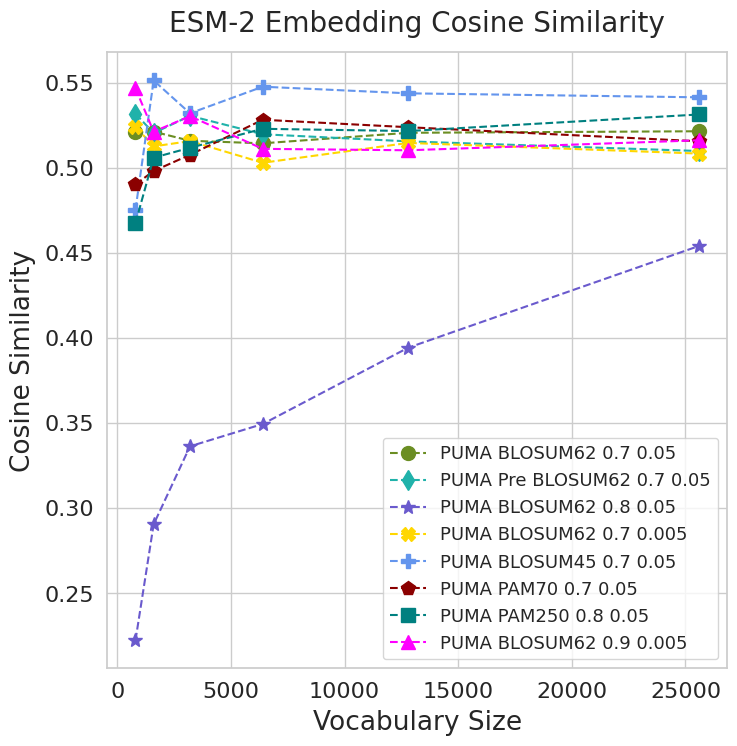

In [30]:
sns.set_style("whitegrid")

for i, method in enumerate(methods):
        plt.plot(vocab_sizes, [results_df[results_df['tokenizer'] == f'{method} {vocab_size}']['rank_win_rate_mut_vs_alt'] for vocab_size in vocab_sizes],
                markers[i],
                color=colors[i],
                linestyle=linestyles[1],
                markersize=10,
                label=methods2names[method])

plt.title(f"ESM-2 Embedding Cosine Similarity", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Cosine Similarity", labelpad=label_pad)
plt.legend()

# plt.xlim([0, 2000])
# plt.ylim([.1, .4])

plt.show()

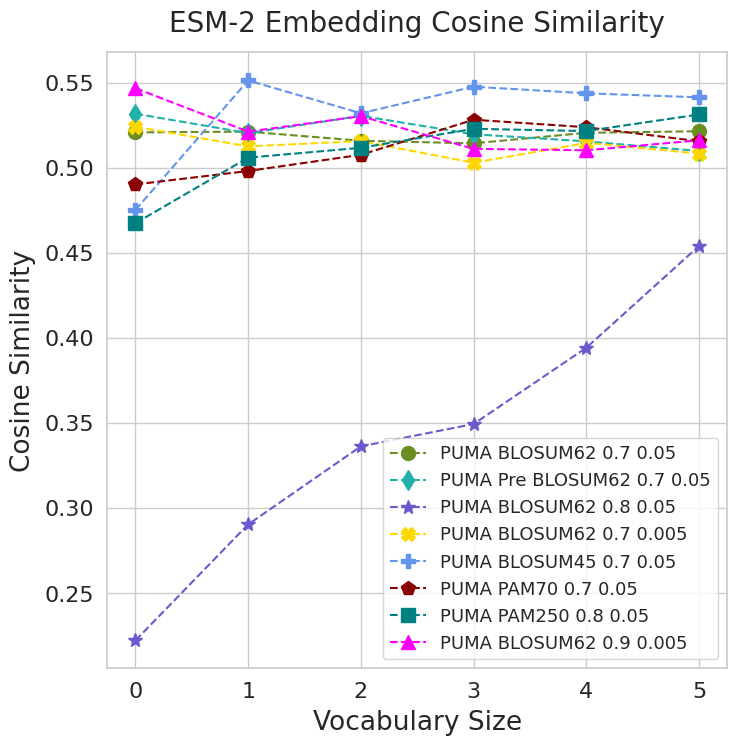

In [32]:
sns.set_style("whitegrid")

for i, method in enumerate(methods):
        plt.plot(range(6), [results_df[results_df['tokenizer'] == f'{method} {vocab_size}']['rank_win_rate_mut_vs_alt'] for vocab_size in vocab_sizes],
                markers[i],
                color=colors[i],
                linestyle=linestyles[1],
                markersize=10,
                label=methods2names[method])

plt.title(f"ESM-2 Embedding Cosine Similarity", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Cosine Similarity", labelpad=label_pad)
plt.legend()

# plt.xlim([0, 2000])
# plt.ylim([.1, .4])

plt.show()

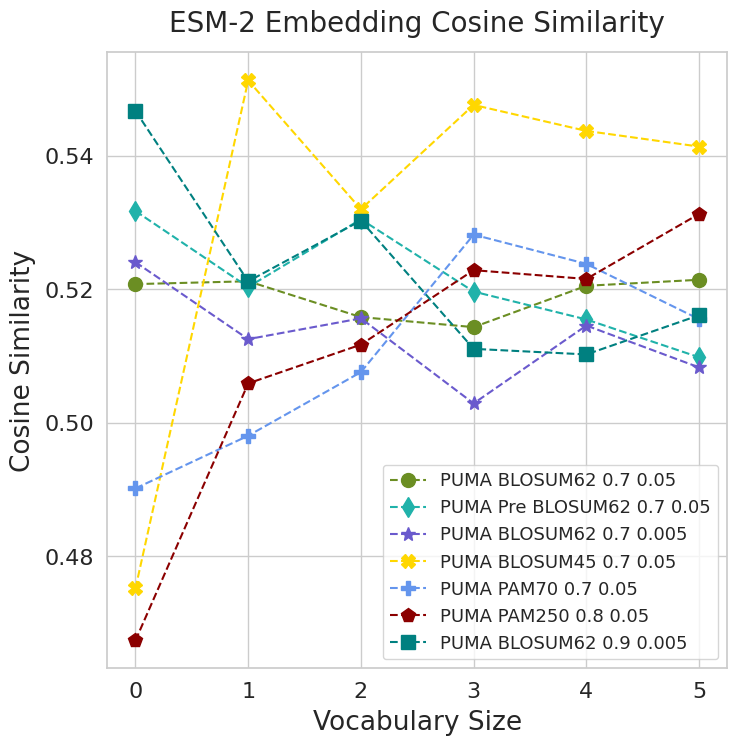

In [33]:
sns.set_style("whitegrid")

for i, method in enumerate(methods[:2]+methods[3:]):
        plt.plot(range(6), [results_df[results_df['tokenizer'] == f'{method} {vocab_size}']['rank_win_rate_mut_vs_alt'] for vocab_size in vocab_sizes],
                markers[i],
                color=colors[i],
                linestyle=linestyles[1],
                markersize=10,
                label=methods2names[method])

plt.title(f"ESM-2 Embedding Cosine Similarity", pad=title_pad)
plt.xlabel("Vocabulary Size", labelpad=label_pad)
plt.ylabel("Cosine Similarity", labelpad=label_pad)
plt.legend()

# plt.xlim([0, 2000])
# plt.ylim([.1, .4])

plt.show()